In [131]:
import os

import numpy as np
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import LinearRL_NHB, SR_NHB
from utils import policy_reval, woodbury
from utils_render import plot_nhb_decisions, create_bar_plot, plot_decision_prob

In [132]:
# Set the random seed for NumPy
seed = 42
np.random.seed(42)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [133]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [134]:
## Hyperparameters for individual plots to make results more similar to NHB
# lambd = 10
# alpha = 0.1
# alpha_SR = 0.2
# beta = 0.9
# num_steps = 115
# num_iterations = 400

## Hyperparameters for plots all together to show a regular agent
lambd = 10
alpha = 0.15
alpha_SR = 0.15
beta = 1.0
num_steps = 250
num_iterations = 400

In [135]:
def softmax(logits, temp=2.0):
    """softmax function for action selection"""
    exp_logits = np.exp(logits / temp - np.max(logits / temp))
    return exp_logits / np.sum(exp_logits)

# Policy Revaluation

## Run Simulations

### Complete Model

In [136]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_complete["test"][dec_test] += 1

### TD Models

In [137]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha_SR, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)
    
    ##  SR  ##
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1


    ##  SR-IS  ##
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_with["test"][dec_test] += 1

    ##  SR-IS no Imp  ##
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_without["test"][dec_test] += 1


In [138]:
print(np.array2string(np.round(agent_with_imp.DR, 3), separator=', ', prefix=' '))

[[1.008, 0.52 , 0.526, 0.226, 0.406, 0.199, 0.025, 0.349, 0.197],
  [0.01 , 1.078, 0.01 , 0.44 , 0.334, 0.01 , 0.045, 0.265, 0.01 ],
  [0.009, 0.009, 1.048, 0.009, 0.507, 0.45 , 0.009, 0.478, 0.446],
  [0.01 , 0.01 , 0.01 , 1.003, 0.01 , 0.01 , 0.285, 0.01 , 0.01 ],
  [0.009, 0.009, 0.009, 0.009, 1.009, 0.009, 0.009, 0.972, 0.009],
  [0.009, 0.009, 0.009, 0.009, 0.009, 1.009, 0.009, 0.009, 1.   ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105, 0.01 , 0.01 ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105, 0.01 ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105]]


In [139]:
print(choices_with)
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

{'train': array([  0, 400]), 'test': array([231, 169])}
selected state 1: 0.5775

{'train': array([  1, 399]), 'test': array([183, 217])}
selected state 1: 0.4575


## Action Selection Probs

### Complete

In [140]:
prob_policy_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_policy_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [141]:
prob_policy_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_policy_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [142]:
# Train
prob_policy_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_policy_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_policy_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [143]:
# Train
prob_policy_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_policy_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_policy_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Reward Revaluation

## Run Simulations

### Complete Model

In [144]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_complete["test"][dec_test] += 1

### TD Models

In [145]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha_SR, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)

    ## SR
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1
    
    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1

In [146]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.6525

{'train': array([  0, 400]), 'test': array([221, 179])}
selected state 1: 0.5525


In [147]:
print(np.array2string(np.round(agent_with_imp.DR, 3), separator=', ', prefix=' '))

[[0.961, 0.301, 0.506, 0.162, 0.248, 0.217, 0.074, 0.134, 0.215],
  [0.009, 0.989, 0.009, 0.36 , 0.334, 0.009, 0.174, 0.21 , 0.009],
  [0.007, 0.007, 0.852, 0.007, 0.309, 0.469, 0.007, 0.17 , 0.464],
  [0.009, 0.009, 0.009, 1.007, 0.009, 0.009, 0.73 , 0.009, 0.009],
  [0.009, 0.009, 0.009, 0.009, 1.006, 0.009, 0.009, 0.683, 0.009],
  [0.009, 0.009, 0.009, 0.009, 0.009, 1.009, 0.009, 0.009, 1.   ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105, 0.01 , 0.01 ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105, 0.01 ],
  [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 1.105]]


## Action Selection Probs

### Complete

In [148]:
prob_reward_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_reward_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [149]:
prob_reward_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_reward_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [150]:
# Train
prob_reward_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_reward_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_reward_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [151]:
# Train
prob_reward_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_reward_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_reward_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Transition Revaluation

## Run Simulations

In [152]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="trans_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)

    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_with_imp.construct_T_new()
    D_new = woodbury(agent=agent_with_imp, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent_with_imp.DR = D_new
    agent_with_imp.update_Z()
    # print(agent_with_imp.Z)
    # print(np.abs(agent_with_imp.Z))
    # agent_with_imp.Z = np.abs(agent_with_imp.Z)
    # agent_with_imp.Z += np.abs(np.min(agent_with_imp.Z)) + 0.01
    agent_with_imp.update_V()
    V_new = agent_with_imp.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training task
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_without_imp.construct_T_new()
    D_new = woodbury(agent=agent_without_imp, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent_without_imp.DR = D_new
    agent_without_imp.update_Z()
    # agent_without_imp.Z += np.abs(np.min(agent_without_imp.Z)) + 0.5
    agent_without_imp.update_V()
    V_new = agent_without_imp.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]])) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_without["test"][dec_test] += 1

In [153]:
print(np.array2string(np.round(agent_with_imp.DR, 3), separator=', ', prefix=' '))

[[1.011, 0.414, 0.6  , 0.373, 0.366, 0.254, 0.27 , 0.264, 0.253],
  [0.15 , 1.037, 0.15 , 0.068, 0.444, 0.551, 0.01 , 0.332, 0.548],
  [0.149, 0.149, 0.913, 0.494, 0.422, 0.22 , 0.398, 0.297, 0.22 ],
  [0.151, 0.151, 0.151, 1.053, 0.151, 0.151, 0.803, 0.151, 0.151],
  [0.151, 0.151, 0.151, 0.151, 1.053, 0.151, 0.151, 0.76 , 0.151],
  [0.15 , 0.15 , 0.15 , 0.15 , 0.15 , 1.055, 0.15 , 0.15 , 1.047],
  [0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 1.142, 0.151, 0.151],
  [0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 1.142, 0.151],
  [0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 0.151, 1.142]]


In [154]:
print(choices_with)
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

{'train': array([  0, 400]), 'test': array([227, 173])}
selected state 1: 0.5675

{'train': array([  0, 400]), 'test': array([213, 187])}
selected state 1: 0.5325


## Action Selection Probs

### With Importance Sampling

In [62]:
# Train
prob_transition_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_transition_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_transition_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [63]:
# Train
prob_transition_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_transition_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_transition_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Plot Simulation Results

## With Importance Sampling

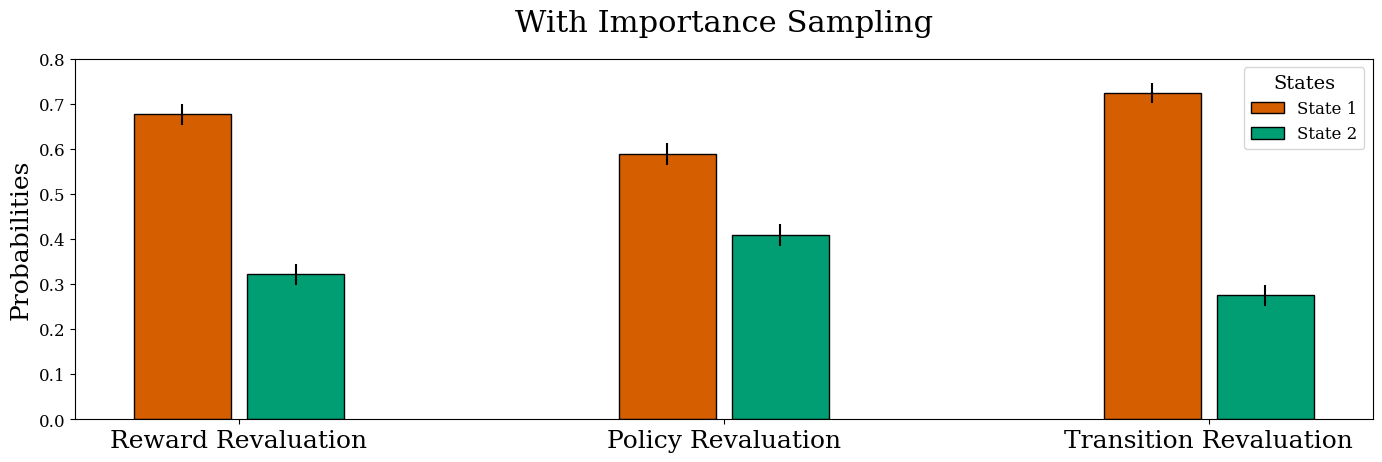

In [64]:
# save_path = save_dir + "nhb_simulations_with.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_with,
    probs_policy=prob_policy_with,
    probs_transition=prob_transition_with,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='With Importance Sampling',
    std=[std_reward_with, std_policy_with, std_transition_with]
)

## Without Importance Sampling

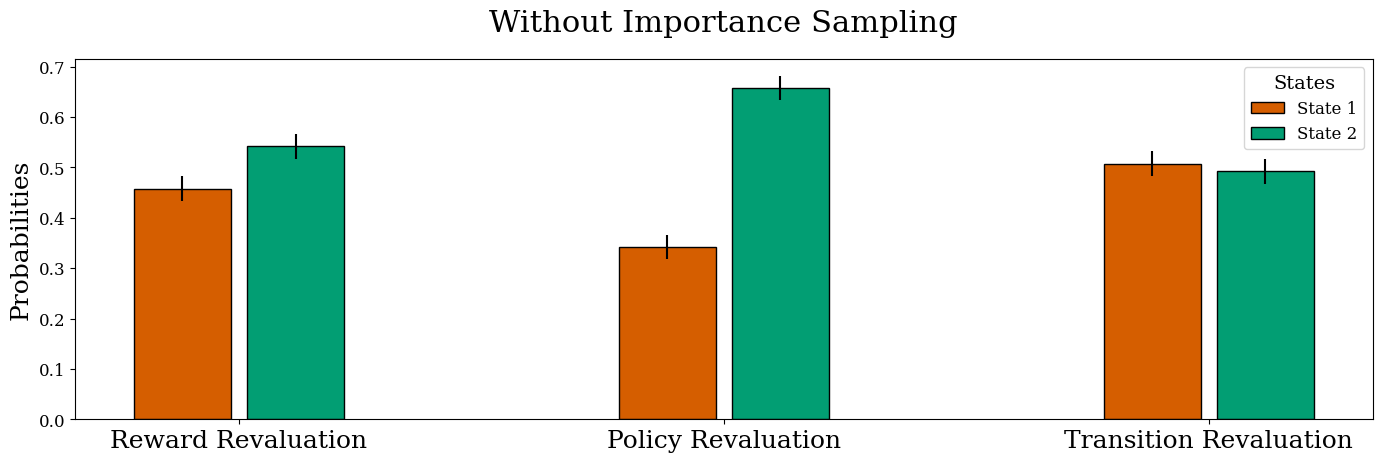

In [43]:
# save_path = save_dir + "nhb_simulations_without.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_without,
    probs_policy=prob_policy_without,
    probs_transition=prob_transition_without,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='Without Importance Sampling',
    std=[std_reward_without, std_policy_without, std_transition_without]
)

# Plot NHB values against ours

## NHB reconstruction

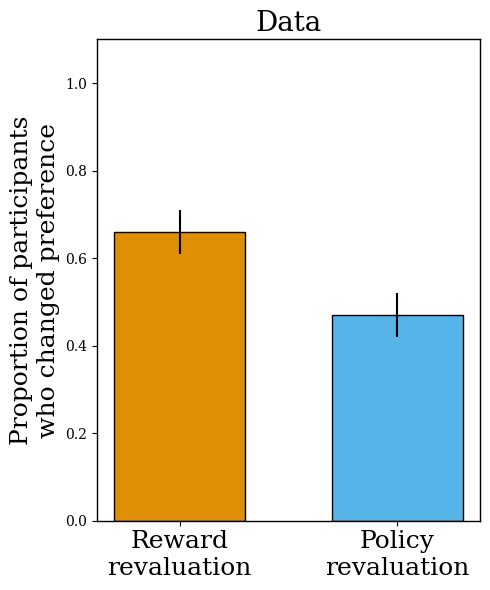

In [44]:
# save_path = save_dir + "NHB_data.png"
save_path = None
nhb_means = [0.66, 0.47]
nhb_stds = [0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Proportion of participants\nwho changed preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data")

## With Importance Sampling

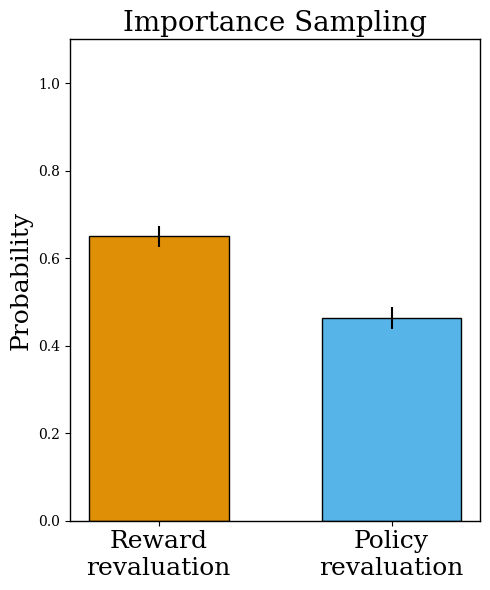

In [45]:
# save_path = save_dir + "NHB_with_imp.png"
save_path = None
means = [prob_reward_with[0], prob_policy_with[0]]
stds = [std_reward_with, std_policy_with]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Importance Sampling")

## SR

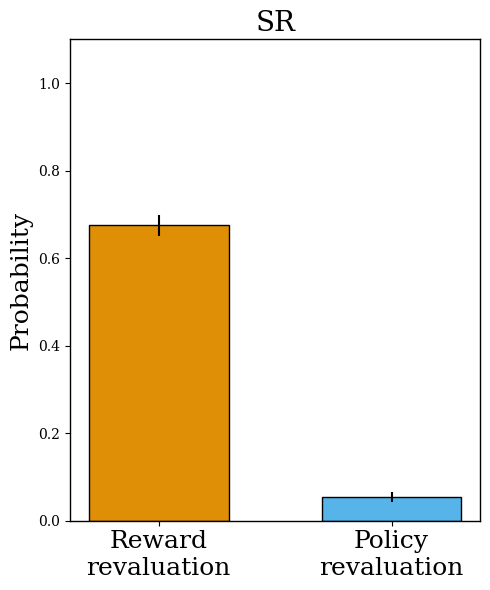

In [46]:
# save_path = save_dir + "NHB_SR.png"
save_path = None
means = [prob_reward_sr[0], prob_policy_sr[0]]
stds = [std_reward_sr, std_policy_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR")

## Complete Model

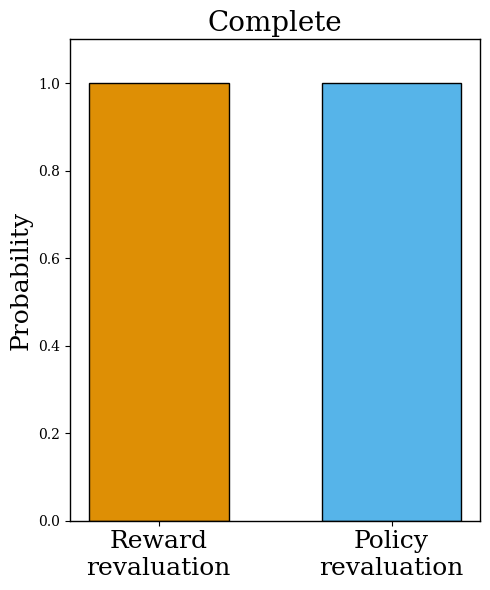

In [47]:
# save_path = save_dir + "NHB_Complete.png"
save_path = None
means = [prob_reward_complete[0], prob_policy_complete[0]]
stds = [std_reward_complete, std_policy_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Complete")

<br> <br> <br>

# Supp. Figures contain both with and without importance sampling

## Reward Revaluation

### With importance sampling

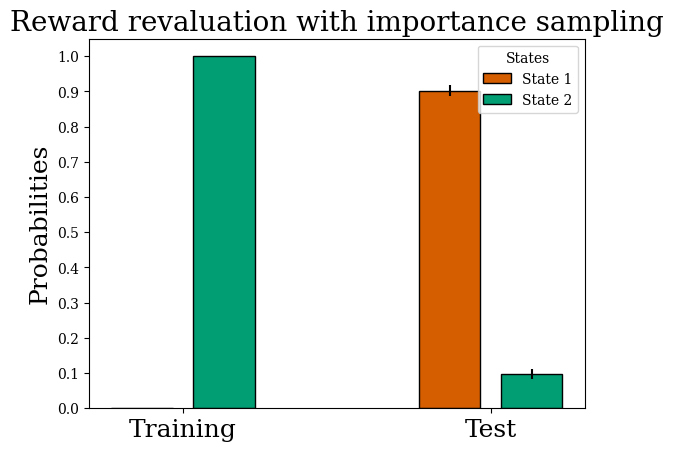

In [30]:
plot_decision_prob(probs_train=prob_reward_with_train, probs_test=prob_reward_with, title="Reward revaluation with importance sampling", 
                   std=[std_reward_with_train, std_reward_with], colors=colors, save_path=None)

### Without importance sampling

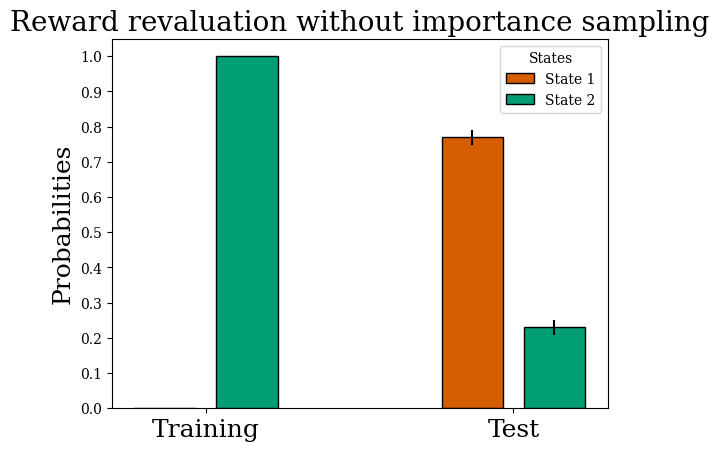

In [31]:
plot_decision_prob(probs_train=prob_reward_without_train, probs_test=prob_reward_without, title="Reward revaluation without importance sampling", 
                   std=[std_reward_without_train, std_reward_without], colors=colors, save_path=None)

## Policy Revaluation

### With importance sampling

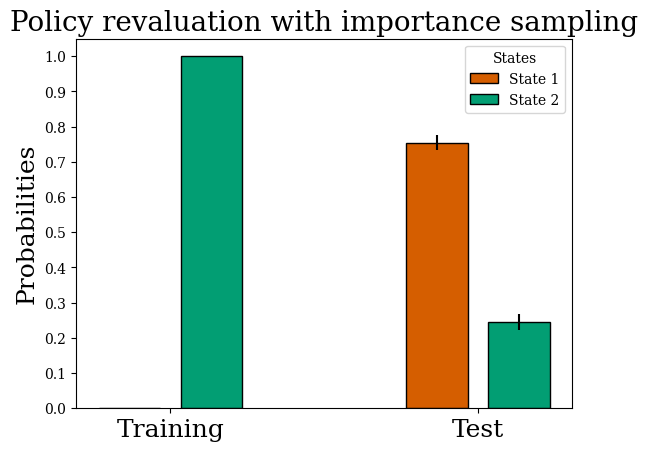

In [32]:
plot_decision_prob(probs_train=prob_policy_with_train, probs_test=prob_policy_with, title="Policy revaluation with importance sampling", 
                   std=[std_policy_with_train, std_policy_with], colors=colors, save_path=None)

### Without importance sampling

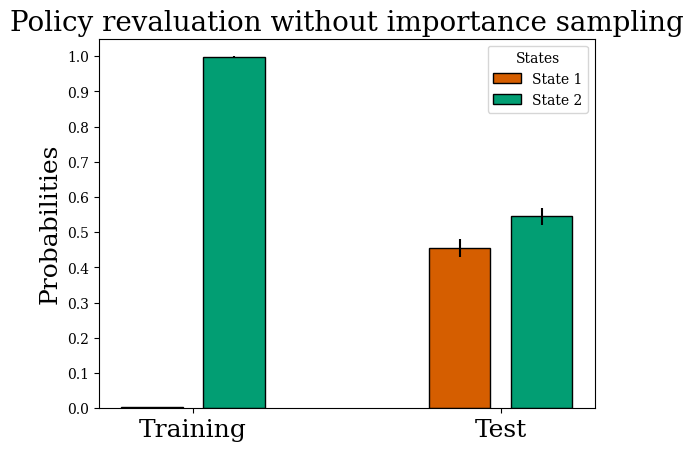

In [33]:
plot_decision_prob(probs_train=prob_policy_without_train, probs_test=prob_policy_without, title="Policy revaluation without importance sampling", 
                   std=[std_policy_without_train, std_policy_without], colors=colors, save_path=None)

## Transition Revaluation

### With importance sampling

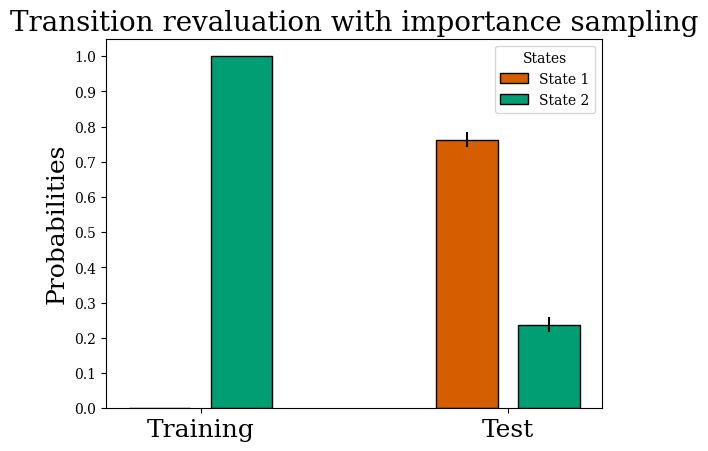

In [34]:
plot_decision_prob(probs_train=prob_transition_with_train, probs_test=prob_transition_with, title="Transition revaluation with importance sampling", 
                   std=[std_transition_with_train, std_transition_with], colors=colors, save_path=None)

### Without importance sampling

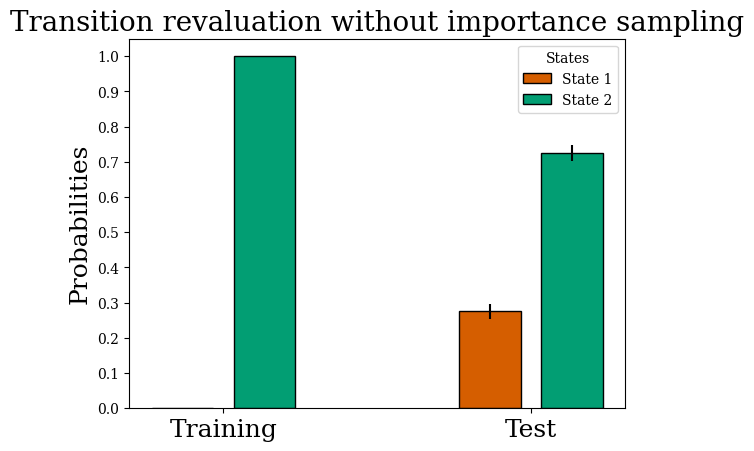

In [35]:
plot_decision_prob(probs_train=prob_transition_without_train, probs_test=prob_transition_without, title="Transition revaluation without importance sampling", 
                   std=[std_transition_without_train, std_transition_without], colors=colors, save_path=None)